## Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os
import cv2 as cv

## Set all the Constants

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

### making a check to find out if I am in the right folder and displaying a sample image

In [ ]:
data_dir = "/content/drive/MyDrive/anemia/anemic dataset"

In [ ]:
os.listdir(data_dir)

['Non-anemic', 'Anemic']

In [ ]:
for image_class in os.listdir(data_dir):
    print(image_class)

Non-anemic
Anemic


In [ ]:
dataset = tf.keras.utils.image_dataset_from_directory("/content/drive/MyDrive/anemia/anemic dataset")

Found 710 files belonging to 2 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Anemic', 'Non-anemic']

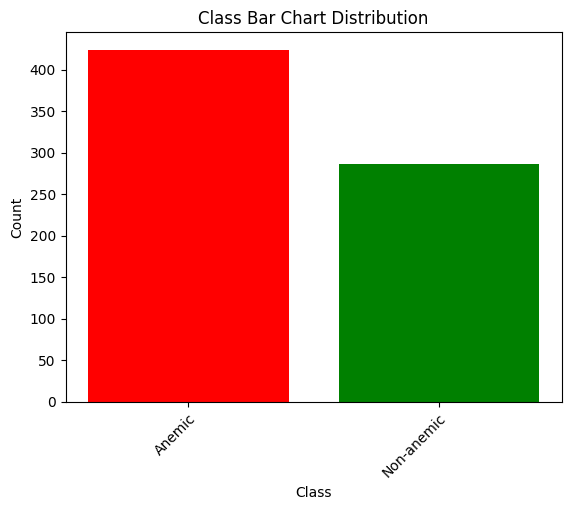

In [ ]:
import matplotlib.pyplot as plt

# Define the class labels and counts
class_labels = ['Anemic', 'Non-anemic']
class_counts = [424, 286]

# Define the colors for each bar
bar_colors = ['red', 'green']

# Create the bar chart
plt.bar(class_labels, class_counts, color=bar_colors)
plt.title("Class Bar Chart Distribution")
plt.xlabel("Class")
plt.ylabel("Count")

# Add elevation to the bars
plt.setp(plt.gca().get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

plt.show()

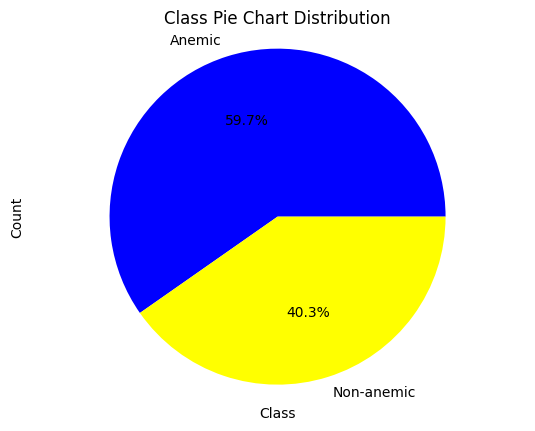

In [ ]:
import matplotlib.pyplot as plt

# Define the class labels and counts
class_labels = ['Anemic', 'Non-anemic']
class_counts = [424, 286]

# Define the colors for each wedge
wedge_colors = ['blue', 'yellow']

# Create the 3D pie chart
plt.pie(class_counts, labels=class_labels, autopct="%1.1f%%", colors=wedge_colors)
plt.title("Class Pie Chart Distribution")

# Add elevation to the pie chart
plt.setp(plt.gca(), xlabel='Class', ylabel='Count')

# Make the pie chart 3D
plt.axis('equal')  # Equal aspect ratio ensures a circular pie chart
plt.show()

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 1 0 0]


## Visualize some of the images from our dataset

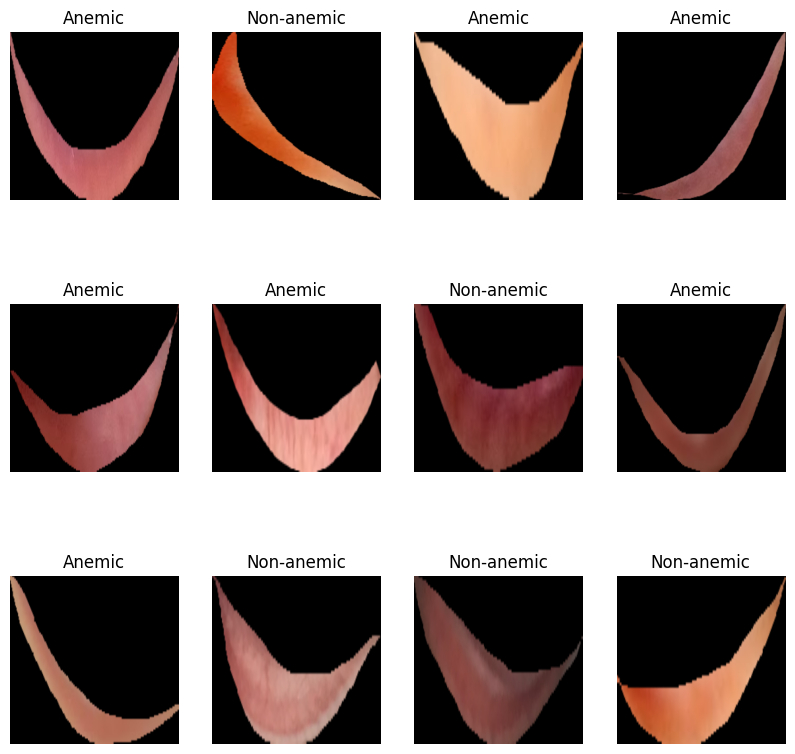

In [ ]:
plt.figure(figsize = (10,10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i +1 )
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
#         plt.title(labels_batch[i].numpy())
#         if  class_names[labels_batch[i]] == "Blight":
#             plt.title("love")
        plt.axis("off")

In [ ]:
len(dataset)

23

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(test_ds)

3

## Cache, Shuffle, and Prefetch the Dataset

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### Applying Data Augmentation to Train Dataset

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [ ]:
model.compile(
    optimizer='adam',
  #  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/20
18/18 [==============================] - 122s 5s/step - loss: 0.8843 - accuracy: 0.5255 - val_loss: 0.7151 - val_accuracy: 0.5156
Epoch 2/20
18/18 [==============================] - 68s 4s/step - loss: 0.7110 - accuracy: 0.5400 - val_loss: 0.6780 - val_accuracy: 0.6094
Epoch 3/20
18/18 [==============================] - 72s 4s/step - loss: 0.6966 - accuracy: 0.5818 - val_loss: 0.7020 - val_accuracy: 0.3750
Epoch 4/20
18/18 [==============================] - 72s 4s/step - loss: 0.6925 - accuracy: 0.5436 - val_loss: 0.6706 - val_accuracy: 0.6250
Epoch 5/20
18/18 [==============================] - 70s 4s/step - loss: 0.6892 - accuracy: 0.5873 - val_loss: 0.6651 - val_accuracy: 0.6250
Epoch 6/20
18/18 [==============================] - 68s 4s/step - loss: 0.6934 - accuracy: 0.5782 - val_loss: 0.6633 - val_accuracy: 0.6250
Epoch 7/20
18/18 [==============================] - 70s 4s/step - loss: 0.6840 - accuracy: 0.5855 - val_loss: 0.6689 - val_accuracy: 0.6250
Epoch 8/20
18/18 [=

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report
import numpy as np

In [ ]:
scores = model.evaluate(test_ds)

3/3 [==============================] - 2s 984ms/step - loss: 0.6649 - accuracy: 0.7286


In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 31}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history.history['loss'][:5]

[0.8843055367469788,
 0.7109651565551758,
 0.6966109871864319,
 0.6924709677696228,
 0.6892127394676208]

### Plotting the Accuracy and Loss Curves

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

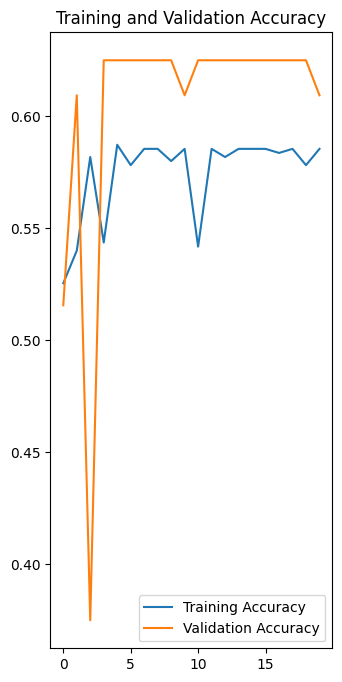

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')



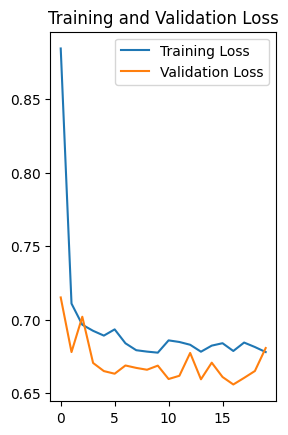

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Anemic
1/1 [==============================] - 2s 2s/step
predicted label: Anemic


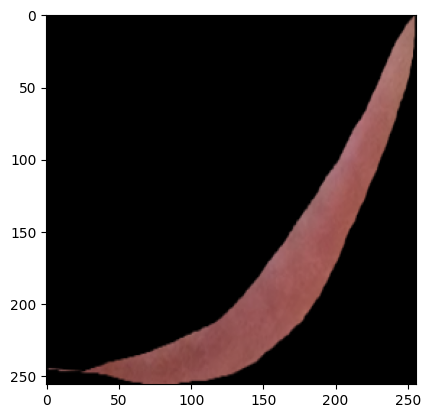

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

### Now run inference on few sample images

1/1 [==============================] - 0s 153ms/step


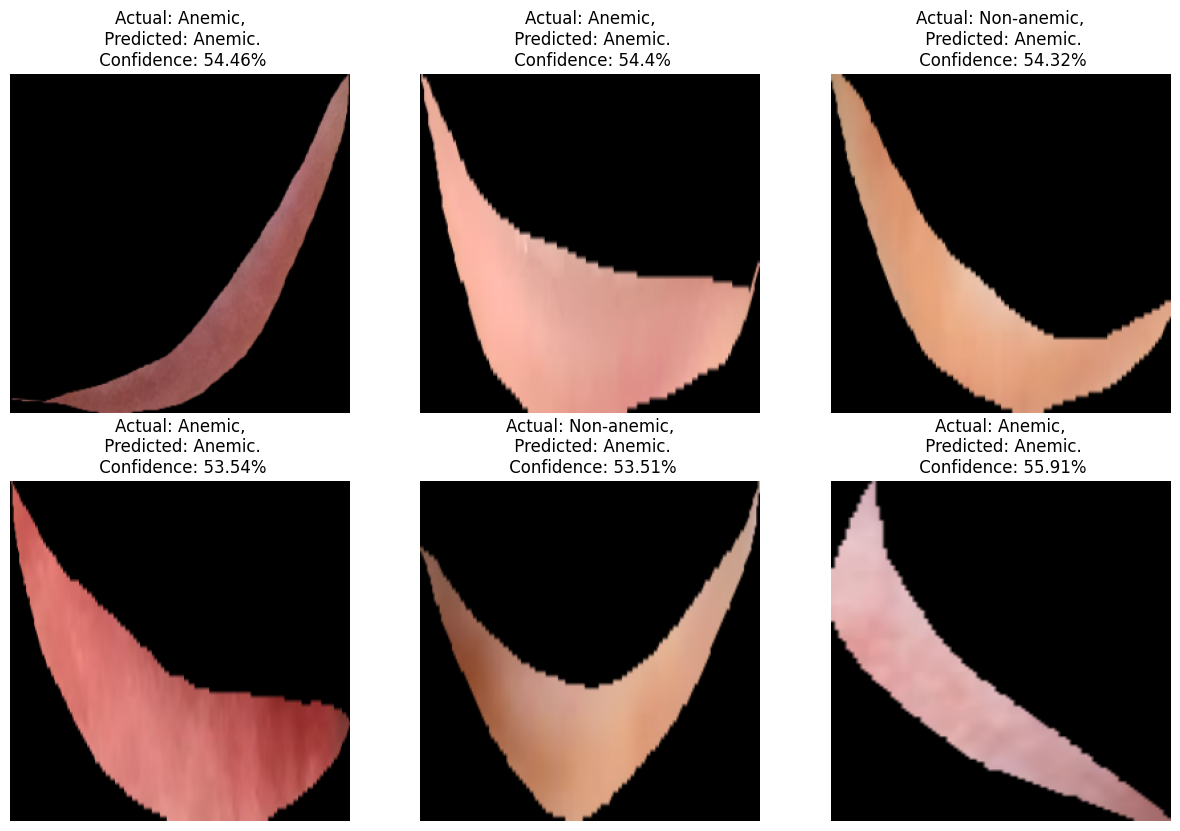

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
model.save("../cannew.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
